## 0. Getting Setup

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

In [4]:
def download_data(source : str,
                  destination : str,
                  remove_source: bool = True):
  """Downloads a zipped dataset from source and unzips to destination.
    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
  """
  import os
  import pathlib
  import requests
  import zipfile

  data_path = pathlib.Path("data/")
  image_path = data_path / destination

  if image_path.is_dir():
    print(f"[INFO] {image_path} directory exists, skipping download.")
  else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents = True, exist_ok = True)

  target_file = pathlib.Path(source).name
  with open(data_path /target_file, "wb") as f:
    request = requests.get(source)
    print(f"[INFO] Downloading {target_file} from {source}...")
    f.write(request.content)

  with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
    print(f"[INFO] Unzipping {target_file} data...")
    zip_ref.extractall(image_path)

  if remove_source:
            os.remove(data_path / target_file)

  return image_path

In [5]:
data_20_percent_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination = "pizza_steak_sushi_20_percent",
                                     )
data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [6]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model with EffNetB2

### 2.1 Creating a function to make an EffNetB2 feature extractor

In [7]:
def create_effnetb2_model(num_classes : int = 3, seed : int = 42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for params in model.parameters():
    params.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3),
      nn.Linear(in_features = 1408, out_features = num_classes)
  )

  return model, transforms

In [8]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 69.7MB/s]


In [9]:
summary(model = effnetb2,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 2.2 Creating DataLoaders for EffNetB2

In [10]:
import os
num_workers = os.cpu_count()
def create_dataLoaders(train_dir: str,
                       test_dir: str,
                       transform : torchvision.transforms.Compose,
                       batch_size: int,
                       num_workers: int = num_workers):
  train_dataset = torchvision.datasets.ImageFolder(train_dir, transform = transform)
  test_dataset = torchvision.datasets.ImageFolder(test_dir, transform = transform)

  classes = train_dataset.classes

  train_dataLoader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
  test_dataLoader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)

  return train_dataLoader, test_dataLoader, classes

In [11]:
batch_size = 32
effnetb2_train_dataLoader, effnetb2_test_dataLoader, effnetb2_classes = create_dataLoaders(train_dir, test_dir, effnetb2_transforms, batch_size = batch_size)

In [13]:
effnetb2_train_dataLoader, effnetb2_test_dataLoader, effnetb2_classes

(<torch.utils.data.dataloader.DataLoader at 0x7b7a2d64a150>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Training EffNetB2

In [14]:
optimizer = torch.optim.Adam(effnetb2.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

In [18]:
def train_step(model: torch.nn.Module,
               dataLoader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataLoader):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    train_logits = model(X)
    loss = loss_fn(train_logits, y)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()

    train_preds = torch.argmax(torch.softmax(train_logits, dim = 1), dim = 1)
    train_acc += (train_preds == y).sum().item() / len(train_logits)

  train_loss = train_loss / len(dataLoader)
  train_acc = train_acc / len(dataLoader)

  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataLoader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device
              ):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataLoader):
      X, y = X.to(device), y.to(device)
      test_logits = model(X)
      loss = loss_fn(test_logits, y)
      test_loss += loss.item()
      test_preds = torch.argmax(test_logits, dim = 1)
      test_acc += ((test_preds == y).sum().item() / len(test_preds))
    test_loss = test_loss / len(dataLoader)
    test_acc = test_acc / len(dataLoader)

  return test_loss, test_acc

def train_test(model : torch.nn.Module,
               train_dataLoader : torch.utils.data.DataLoader,
               test_dataLoader : torch.utils.data.DataLoader,
               optimizer : torch.optim.Optimizer,
               loss_fn : torch.nn.Module,
               epochs : int,
               device : torch.device):

  results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

  model.to(device)

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model = model,
                                       dataLoader = train_dataLoader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device
                                       )
    test_loss, test_acc = test_step(model = model,
                                    dataLoader = test_dataLoader,
                                    loss_fn = loss_fn,
                                    device = device)

    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [19]:
effnetb2_results = train_test(model = effnetb2,
           train_dataLoader = effnetb2_train_dataLoader,
           test_dataLoader = effnetb2_test_dataLoader,
           optimizer = optimizer,
           loss_fn = loss_fn,
           epochs = 10,
           device = device)

effnetb2_results

Epoch: 1 | train_loss: 0.3504 | train_acc: 0.8625 | test_loss: 0.2754 | test_acc: 0.9318
Epoch: 2 | train_loss: 0.2702 | train_acc: 0.9437 | test_loss: 0.2693 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.2513 | train_acc: 0.9500 | test_loss: 0.2804 | test_acc: 0.9506
Epoch: 4 | train_loss: 0.2488 | train_acc: 0.9417 | test_loss: 0.2539 | test_acc: 0.9534
Epoch: 5 | train_loss: 0.3030 | train_acc: 0.9021 | test_loss: 0.2510 | test_acc: 0.9256
Epoch: 6 | train_loss: 0.2814 | train_acc: 0.9125 | test_loss: 0.2671 | test_acc: 0.9108
Epoch: 7 | train_loss: 0.3139 | train_acc: 0.8979 | test_loss: 0.2500 | test_acc: 0.9381
Epoch: 8 | train_loss: 0.2585 | train_acc: 0.9208 | test_loss: 0.2420 | test_acc: 0.9290
Epoch: 9 | train_loss: 0.2958 | train_acc: 0.9000 | test_loss: 0.2380 | test_acc: 0.9409
Epoch: 10 | train_loss: 0.1928 | train_acc: 0.9542 | test_loss: 0.2621 | test_acc: 0.9290


{'train_loss': [0.3504352996746699,
  0.27021722694238026,
  0.25127012729644777,
  0.24880375762780507,
  0.30302891532580056,
  0.2813721030950546,
  0.3138655165831248,
  0.2585172732671102,
  0.2957779198884964,
  0.19275291015704474],
 'train_acc': [0.8625,
  0.94375,
  0.95,
  0.9416666666666667,
  0.9020833333333333,
  0.9125,
  0.8979166666666667,
  0.9208333333333333,
  0.9,
  0.9541666666666667],
 'test_loss': [0.2754449248313904,
  0.2693226158618927,
  0.28041161596775055,
  0.25394303500652315,
  0.2509700894355774,
  0.267135351896286,
  0.2500262752175331,
  0.241960871219635,
  0.23797574937343596,
  0.2621349781751633],
 'test_acc': [0.9318181818181819,
  0.940909090909091,
  0.9505681818181818,
  0.953409090909091,
  0.9255681818181818,
  0.9107954545454545,
  0.9380681818181819,
  0.9289772727272727,
  0.940909090909091,
  0.9289772727272727]}

### 2.4 Visualize Loss And Acc Values

In [20]:
def plot_loss_curves(results):
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure()
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label = "train_acc")
  plt.plot(epochs, test_acc, label = "test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

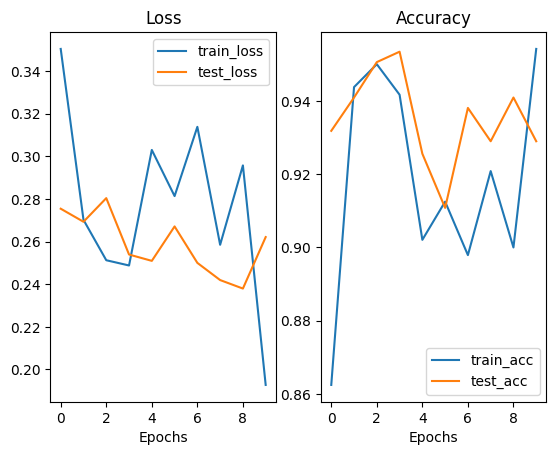

In [21]:
plot_loss_curves(effnetb2_results)

### 2.5 Saving EffnetB2

In [22]:
import pathlib
def save_model(model: torch.nn.Module,
               target_dir : str,
               model_name : str):

  target_dir_path = pathlib.Path(target_dir)
  target_dir_path.mkdir(parents = True, exist_ok = True)

  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model name should end with '.pth' or '.pt'."

  model_save_path = target_dir_path / model_name

  print(f"[INFO] Saving model to: {model_save_path}.")
  torch.save(obj = model.state_dict(),
             f =  model_save_path)

save_model(model = effnetb2, target_dir = "models", model_name = "09_pretrained_effnetb2_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_pizza_steak_sushi_20_percent.pth.


### 2.6 Checking the size of EffNetB2 feature extractor

In [23]:
import pathlib
pretrained_effnetb2_model_size = pathlib.Path("models/09_pretrained_effnetb2_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### 2.7 Collecting EffNetB2 feature extractor stats

In [24]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [25]:
effnetb2_stats = {"test_loss" : effnetb2_results["test_loss"][-1],
                  "test_acc" : effnetb2_results["test_acc"][-1],
                  "number_of_parameters" : effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.2621349781751633,
 'test_acc': 0.9289772727272727,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 3. FoodVision Mini model with ViT

In [26]:
def create_vit_b_16_model(num_classes:int=3, seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights = weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads  = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [27]:
vit, vit_transforms = create_vit_b_16_model(num_classes=3, seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 158MB/s]


In [28]:
summary(model = vit,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [29]:
vit_train_dataLoader, vit_test_dataLoader, vit_classes = create_dataLoaders(train_dir = train_dir,
                                                                            test_dir = test_dir,
                                                                            transform = vit_transforms,
                                                                            batch_size = 32)

vit_train_dataLoader, vit_test_dataLoader, vit_classes

(<torch.utils.data.dataloader.DataLoader at 0x7b7a2a546b10>,
 ['pizza', 'steak', 'sushi'])

In [30]:
optimizer = torch.optim.Adam(vit.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

vit_results = train_test(model = vit,
                         train_dataLoader = vit_train_dataLoader,
                         test_dataLoader = vit_test_dataLoader,
                         optimizer = optimizer,
                         loss_fn = loss_fn,
                         epochs = 10,
                         device = device)

Epoch: 1 | train_loss: 0.6173 | train_acc: 0.7854 | test_loss: 0.2692 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.2241 | train_acc: 0.9437 | test_loss: 0.1414 | test_acc: 0.9631
Epoch: 3 | train_loss: 0.1539 | train_acc: 0.9563 | test_loss: 0.1071 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.1412 | train_acc: 0.9625 | test_loss: 0.0966 | test_acc: 0.9693
Epoch: 5 | train_loss: 0.1058 | train_acc: 0.9667 | test_loss: 0.0866 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0903 | train_acc: 0.9729 | test_loss: 0.0823 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0783 | train_acc: 0.9792 | test_loss: 0.0772 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0693 | train_acc: 0.9792 | test_loss: 0.0712 | test_acc: 0.9784
Epoch: 9 | train_loss: 0.0615 | train_acc: 0.9896 | test_loss: 0.0705 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.0548 | train_acc: 0.9938 | test_loss: 0.0667 | test_acc: 0.9722


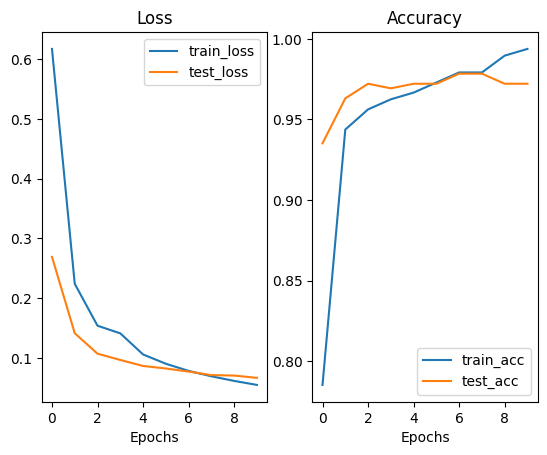

In [31]:
plot_loss_curves(vit_results)

In [32]:
save_model(model = vit, target_dir = "models", model_name = "09_pretrained_vit_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_pizza_steak_sushi_20_percent.pth.


In [33]:
pretrained_vitb16_model_size = pathlib.Path("models/09_pretrained_vit_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT_B_16 feature extractor model size: {pretrained_vitb16_model_size} MB")

Pretrained ViT_B_16 feature extractor model size: 327 MB


In [34]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [35]:
vit_stats = {"test_loss" : vit_results["test_loss"][-1],
             "test_acc" : vit_results["test_acc"][-1],
             "number_of_parameters" : vit_total_params,
             "model_size (MB)": pretrained_vitb16_model_size}

vit_stats

{'test_loss': 0.06667962307110428,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}